# Data preparation

For the prediction of the outcome of the TEAM A X TEAM B game, we will need to prep our data. What we have now:
A table from our SQL database, in which each row contains information about a single game per team.

As we dont have these informations to actually predict a game, the idea behind the process will be: We are going to fill the row which we want to predict for team A X team B, with concatenated features, taking the mean, from the past N games from team A and past N games from team B. We are going to call this the rolling row.

In order to achieve a more reasonable result, we are not using the stats of a single game and the win situation as a row in the training set. Each row will be the rolling row, E.G., each row will cointain data from the last N games, plus the WIN/LOSS target variable of the actual game. Note that the mean of wins for the rolling will be discarded.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
import warnings

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import make_pipeline

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('mode.chained_assignment', None)

We first gonna extract our stored data from the database created on the webscraping step.

In [3]:
engine = sqlalchemy.create_engine('sqlite:///nba_games.db', echo=False)

df = pd.read_sql('SELECT * FROM nba_games', con=engine)

Exploring data

In [4]:
df.head()

,mp,mp.1,fg,fga,fg%,3p,3pa,3p%,ft,fta,...,opponent_tov%_max,opponent_usg%_max,opponent_ortg_max,opponent_drtg_max,opponent_Team,opponent_Total,opponent_season,opponent_date,opponent_home,WIN
0,240.0,240.0,37.0,99.0,0.374,10.0,33.0,0.303,15.0,23.0,...,43.6,40.4,300.0,98.0,BRK,125,2020-21,2020-12-22,1,0
1,240.0,240.0,42.0,92.0,0.457,15.0,35.0,0.429,26.0,32.0,...,50.0,32.1,267.0,120.0,GSW,99,2020-21,2020-12-22,0,1
2,240.0,240.0,44.0,93.0,0.473,14.0,40.0,0.350,14.0,19.0,...,100.0,35.9,166.0,118.0,LAL,109,2020-21,2020-12-22,1,1
3,240.0,240.0,38.0,81.0,0.469,9.0,29.0,0.310,24.0,31.0,...,20.9,40.2,154.0,114.0,LAC,116,2020-21,2020-12-22,0,0
4,240.0,240.0,46.0,90.0,0.511,14.0,35.0,0.400,15.0,18.0,...,33.3,39.2,203.0,126.0,BOS,122,2020-21,2020-12-23,1,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4984 entries, 0 to 4983
Columns: 152 entries, mp to WIN
dtypes: float64(134), int64(6), object(12)
memory usage: 5.8+ MB


In [6]:
df.columns.to_list()

['mp',
 'mp.1',
 'fg',
 'fga',
 'fg%',
 '3p',
 '3pa',
 '3p%',
 'ft',
 'fta',
 'ft%',
 'orb',
 'drb',
 'trb',
 'ast',
 'stl',
 'blk',
 'tov',
 'pf',
 'pts',
 '+/-',
 'ts%',
 'efg%',
 '3par',
 'ftr',
 'orb%',
 'drb%',
 'trb%',
 'ast%',
 'stl%',
 'blk%',
 'tov%',
 'usg%',
 'ortg',
 'drtg',
 'mp_max',
 'mp_max.1',
 'fg_max',
 'fga_max',
 'fg%_max',
 '3p_max',
 '3pa_max',
 '3p%_max',
 'ft_max',
 'fta_max',
 'ft%_max',
 'orb_max',
 'drb_max',
 'trb_max',
 'ast_max',
 'stl_max',
 'blk_max',
 'tov_max',
 'pf_max',
 'pts_max',
 '+/-_max',
 'ts%_max',
 'efg%_max',
 '3par_max',
 'ftr_max',
 'orb%_max',
 'drb%_max',
 'trb%_max',
 'ast%_max',
 'stl%_max',
 'blk%_max',
 'tov%_max',
 'usg%_max',
 'ortg_max',
 'drtg_max',
 'Team',
 'Total',
 'season',
 'date',
 'home',
 'opponent_index',
 'opponent_mp',
 'opponent_mp.1',
 'opponent_fg',
 'opponent_fga',
 'opponent_fg%',
 'opponent_3p',
 'opponent_3pa',
 'opponent_3p%',
 'opponent_ft',
 'opponent_fta',
 'opponent_ft%',
 'opponent_orb',
 'opponent_drb',

## Overtime exceptions
We are going to delete some non useful or redundant info, as well as the rows where the number of minutes played != 240, because these are some outliers that represent much less than 15% of our data, and we will then remove the  mp variable alltogheter

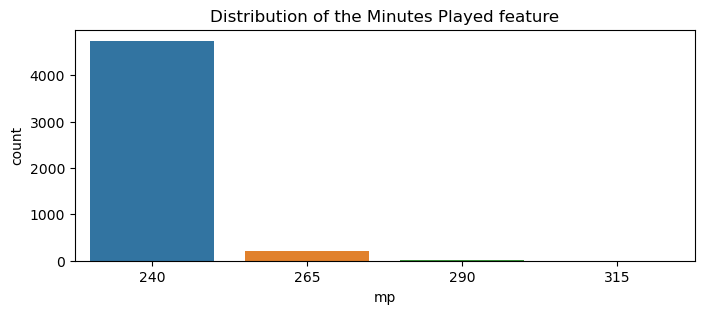

In [7]:
plt.figure(num=1, figsize=(8, 3))

plt.title('Distribution of the Minutes Played feature')
sns.countplot(df['mp'].astype(int)); #type: ignore


In [8]:
print('outliers porcentage: {:.2%}'.format(len(df[df['mp'] != 240])/len(df)))

 #deleting outliers rows   
df = df[df['mp'] == 240]
df.shape

outliers porcentage: 4.78%


(4746, 152)

* We need just one stat for minutes played;
* we will need the +/-_max stats, because the max diference that a player made could be important;
* altough the team name, season, and date are irrelevant for training, they will be important for organization. But these stats for the opponent side could be deleted;


In [9]:
del_list = ['mp','mp.1','+/-','mp_max','mp_max.1',
 'opponent_index','opponent_mp',
 'opponent_mp.1','opponent_+/-','opponent_mp_max.1', 'opponent_mp_max',
   'opponent_date', 'opponent_season', 'opponent_home']


for col in del_list:
    if col in df.columns:
        del df[col]

In [10]:
df.shape

(4746, 138)

Our traning set has to match our predict idea, so each row will be the mean of last few games for each team.
Note that as we are taking last n games per team, conseidering season, and home stats, will lose some information in this way:

if we chose to roll with n games, only the information with n+1 will appear as a row. It means that we lose 2*n rows per team, as each team  are grouped by home or away also.

* Example:
For n = 10 games, being a season having 30 teams, we lose 2 * 10 * 30 = 600 rows per season. But, as we have almost 2500 games in a regular season, it is worth it still, to try numbers like 5 < n < 15

In [11]:
def team_avg(grouped_df, last_n_games=6):
    """ Info:
        This function calculates the rolling average of the features of the team

         Input:
            last_n_games: number of games a team played to calculate the rolling average 
            grouped_df: dataframe grouped by team, season, and home status

             Output:
                rolling: dataframe with the rolling average of the features """
    
    rolling = grouped_df.rolling(last_n_games).mean()
    return rolling

In [12]:
# creating our list of feature cols for ML
info_cols = ['date', 'Team', 'opponent_Team', 'season', 'home', 'WIN']
model_cols = df.columns[~df.columns.isin(info_cols)]	#only usefull for ML columns

In [13]:
#df for rolling is the df with the top valuable features for training plus the columns that we need for the group by. Note that these are columns from the information cols.
df_to_roll = df[list(model_cols) + ['Team','season', 'home'] ]
df_rolling = df_to_roll.groupby(['Team','season', 'home'], group_keys=False).apply(team_avg)
df_rolling.shape

(4746, 133)

In [14]:
df_rolling.tail()

,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,orb,...,opponent_trb%_max,opponent_ast%_max,opponent_stl%_max,opponent_blk%_max,opponent_tov%_max,opponent_usg%_max,opponent_ortg_max,opponent_drtg_max,opponent_Total,home
4979,35.166667,80.333333,0.438333,13.500000,37.833333,0.351500,21.166667,26.666667,0.779833,10.500000,...,22.350000,48.566667,5.316667,13.400000,58.733333,35.100000,155.000000,121.833333,98.333333,1.0
4980,35.833333,80.000000,0.447167,14.666667,35.833333,0.401333,17.333333,22.333333,0.783167,7.500000,...,38.483333,53.616667,5.533333,8.366667,46.183333,37.016667,217.000000,118.333333,99.500000,0.0
4981,42.666667,85.666667,0.499167,13.500000,35.833333,0.381000,14.000000,17.833333,0.787500,8.500000,...,32.116667,77.433333,8.850000,12.350000,50.266667,54.433333,240.666667,126.166667,102.666667,1.0
4982,38.166667,84.333333,0.453667,14.000000,38.000000,0.366167,13.500000,17.000000,0.815500,10.166667,...,29.800000,39.150000,4.716667,11.383333,41.883333,35.650000,189.333333,120.000000,109.333333,0.0
4983,34.666667,79.000000,0.439167,11.666667,33.333333,0.350333,20.833333,25.666667,0.812333,11.000000,...,21.633333,37.850000,6.233333,12.500000,47.616667,33.250000,151.166667,120.333333,102.000000,1.0


Checking for null values

In [15]:
def check_missing_col(dataframe):
    """ Info:
        This function checks if there are missing values in the dataframe
         Input:
            dataframe: dataframe to check
             Output:
              prints the columns with missing values and the number of missing values """
    i = 0
    for col in dataframe.columns:
        if dataframe[col].isnull().sum() > 0:
            print(col, dataframe[col].isna().sum())
            i += 1

    if i == 0:
        print( 'no missing values')

In [16]:
check_missing_col(df_rolling)
df_to_roll.shape

fg 600
fga 600
fg% 600
3p 600
3pa 600
3p% 600
ft 600
fta 600
ft% 600
orb 600
drb 600
trb 600
ast 600
stl 600
blk 600
tov 600
pf 600
pts 600
ts% 600
efg% 600
3par 600
ftr 600
orb% 600
drb% 600
trb% 600
ast% 600
stl% 600
blk% 600
tov% 600
usg% 600
ortg 600
drtg 600
fg_max 600
fga_max 600
fg%_max 600
3p_max 600
3pa_max 600
3p%_max 600
ft_max 600
fta_max 600
ft%_max 600
orb_max 600
drb_max 600
trb_max 600
ast_max 600
stl_max 600
blk_max 600
tov_max 600
pf_max 600
pts_max 600
+/-_max 600
ts%_max 600
efg%_max 600
3par_max 600
ftr_max 600
orb%_max 600
drb%_max 600
trb%_max 600
ast%_max 600
stl%_max 600
blk%_max 600
tov%_max 600
usg%_max 600
ortg_max 600
drtg_max 600
Total 600
opponent_fg 600
opponent_fga 600
opponent_fg% 600
opponent_3p 600
opponent_3pa 600
opponent_3p% 600
opponent_ft 600
opponent_fta 600
opponent_ft% 600
opponent_orb 600
opponent_drb 600
opponent_trb 600
opponent_ast 600
opponent_stl 600
opponent_blk 600
opponent_tov 600
opponent_pf 600
opponent_pts 600
opponent_ts% 600
opp

(4746, 135)

Combining our avg rows with our original dataframe;
So we gonna keep only thse informations cols from our original df. In this way, our model will train only with respect of th e past games information for that team, even though there are information in training for the actual game. This is so we can use only what is possible to use for prediction, making it more reliable.

In [17]:
df_rolling.columns.tolist()

['fg',
 'fga',
 'fg%',
 '3p',
 '3pa',
 '3p%',
 'ft',
 'fta',
 'ft%',
 'orb',
 'drb',
 'trb',
 'ast',
 'stl',
 'blk',
 'tov',
 'pf',
 'pts',
 'ts%',
 'efg%',
 '3par',
 'ftr',
 'orb%',
 'drb%',
 'trb%',
 'ast%',
 'stl%',
 'blk%',
 'tov%',
 'usg%',
 'ortg',
 'drtg',
 'fg_max',
 'fga_max',
 'fg%_max',
 '3p_max',
 '3pa_max',
 '3p%_max',
 'ft_max',
 'fta_max',
 'ft%_max',
 'orb_max',
 'drb_max',
 'trb_max',
 'ast_max',
 'stl_max',
 'blk_max',
 'tov_max',
 'pf_max',
 'pts_max',
 '+/-_max',
 'ts%_max',
 'efg%_max',
 '3par_max',
 'ftr_max',
 'orb%_max',
 'drb%_max',
 'trb%_max',
 'ast%_max',
 'stl%_max',
 'blk%_max',
 'tov%_max',
 'usg%_max',
 'ortg_max',
 'drtg_max',
 'Total',
 'opponent_fg',
 'opponent_fga',
 'opponent_fg%',
 'opponent_3p',
 'opponent_3pa',
 'opponent_3p%',
 'opponent_ft',
 'opponent_fta',
 'opponent_ft%',
 'opponent_orb',
 'opponent_drb',
 'opponent_trb',
 'opponent_ast',
 'opponent_stl',
 'opponent_blk',
 'opponent_tov',
 'opponent_pf',
 'opponent_pts',
 'opponent_ts%',
 'o

In [18]:
# first, we rename the columns to add the rolling prefix
df_rolling.columns = ['rolling_' + col for col in df_rolling.columns]
# then, we merge the rolling df with the original df
df_combined = df[['date', 'home', 'Team', 'opponent_Team', 'season', 'WIN']].merge(df_rolling, left_index=True, right_index=True)
print(df_combined.shape)
df_combined[[ 'date', 'home', 'Team', 'opponent_Team','season', 'rolling_pts', 'rolling_opponent_pts', 'WIN']].tail()

(4746, 139)


,date,home,Team,opponent_Team,season,rolling_pts,rolling_opponent_pts,WIN
4979,2022-06-10,1,BOS,GSW,2021-22,105.000000,98.333333,0
4980,2022-06-13,0,BOS,GSW,2021-22,103.666667,99.500000,0
4981,2022-06-13,1,GSW,BOS,2021-22,112.833333,102.666667,1
4982,2022-06-16,0,GSW,BOS,2021-22,103.833333,109.333333,1
4983,2022-06-16,1,BOS,GSW,2021-22,101.833333,102.000000,0


From the end of the dataframe, we can see that we have reliable features because for example, even tho the avg points of past 10 games of the BOSTON CELTICS team were higher then the last 10 opponents avg, they still lost the actual game.

In [19]:
# deleting the rows with missing values
df_combined.dropna(inplace=True)
df_combined.shape

(4146, 139)

We now have rows for each team, being each the last n games. Those are also tagged propperly in order with the date/ index right sorting. We should add those cols for the opponent team too. As in a prediction, we would have the information about the past 10 games, plus the home, season, and date, and of course the win/loss.


We can do this by combining a dataframe with the home teams names with a dataframe with away teams. We do this by joining the columns 'Team' and 'opponent_Team' and  using the date as same index.


In [20]:
# creating the home and away df

home = df_combined.loc[df_combined['home'] == 1]
# adding the home prefix to the columns
home.columns = ['home_' + col for col in home.columns] #type: ignore

away = df_combined.loc[df_combined['home'] == 0]
# adding the away prefix to the columns 
away.columns = ['away_' + col for col in away.columns] #type: ignore


We need to swap the names of the columns in the away team so it is considered the opponent team

In [21]:
# to join the columns, we need to rename the team columns on the away df
away.rename(columns={'away_Team': 'opponent_Team', 'away_opponent_Team': 'Team', 'away_date': 'date'}, inplace=True) 
home.rename(columns={'home_Team': 'Team', 'home_opponent_Team': 'opponent_Team', 'home_date': 'date'}, inplace=True)

In [22]:
#merging the home and away df
df_full = home.merge(away, on=['Team', 'opponent_Team', 'date']) 
print(df_full.shape)
df_full[['date','Team', 'opponent_Team', 'home_season', 'home_rolling_pts', 'away_rolling_pts', 'home_WIN']].head(25) 

(2027, 275)


,date,Team,opponent_Team,home_season,home_rolling_pts,away_rolling_pts,home_WIN
0,2021-01-08,LAL,CHI,2020-21,117.833333,115.666667,1
1,2021-01-09,MIL,CLE,2020-21,122.833333,92.666667,1
2,2021-01-10,BRK,OKC,2020-21,121.833333,108.000000,0
3,2021-01-10,GSW,TOR,2020-21,115.666667,114.500000,1
4,2021-01-11,WAS,PHO,2020-21,120.333333,110.500000,1
5,2021-01-12,HOU,LAL,2020-21,109.666667,111.500000,0
6,2021-01-13,CHO,DAL,2020-21,103.500000,111.000000,0
7,2021-01-13,SAC,POR,2020-21,121.333333,120.333333,0
8,2021-01-15,CLE,NYK,2020-21,101.500000,98.000000,1
9,2021-01-15,LAL,NOP,2020-21,118.333333,101.833333,1


## We have now our full dataset of features, ready for feature engineering/training!

In [28]:
df_full.columns

Index(['date', 'home_home', 'Team', 'opponent_Team', 'home_season', 'home_WIN',
       'home_rolling_fg', 'home_rolling_fga', 'home_rolling_fg%',
       'home_rolling_3p',
       ...
       'away_rolling_opponent_trb%_max', 'away_rolling_opponent_ast%_max',
       'away_rolling_opponent_stl%_max', 'away_rolling_opponent_blk%_max',
       'away_rolling_opponent_tov%_max', 'away_rolling_opponent_usg%_max',
       'away_rolling_opponent_ortg_max', 'away_rolling_opponent_drtg_max',
       'away_rolling_opponent_Total', 'away_rolling_home'],
      dtype='object', length=275)